#  <font color='#FFE15D'><b>💎 UW-Madison GI Tract Image Segmentation 🔬</b></font>
![Image Title](images/cover.png)


# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [1]:
!pip install -q torchmetrics

## 🟠 Install `portalocker`

In [2]:
!pip install -q portalocker>=2.0.0

## 🟠 Install `wandb`

In [3]:
!pip install wandb

# ⚠️ **Don't forget to restart the runtime!**

# 🔴 **Import Libs**

In [101]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torchvision

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from PIL import Image
import pandas as pd
import cv2

import random
import math

In [3]:
!python --version

Python 3.9.13


In [4]:
for lib in [np, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.3
torch --> 2.2.1+cpu
torchvision --> 0.17.1+cpu
tqdm --> 4.66.1


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [103]:
# Convert RLE-segmentation to mask
def decode_rle(rle_string, shape):
    if rle_string == None:
        return None
    
    mask = np.zeros(shape, dtype=np.uint8)

    pairs = np.array(list(map(int, rle_string.split()))).reshape(-1, 2)
    for start, length in pairs:
        start_x = start % shape[1]
        start_y = start // shape[1]
        end_x = min(start_x + length, shape[1])
        mask[start_y, start_x:end_x] = 1

    return mask

In [104]:
# Find annotation nmae from image name
def ann_from_image(image_name):
    image_name = image_name.split("/")
    ann_name = image_name[-4] + '_' + image_name[-3].split("_")[1] + '_slice_' + image_name[-1].split("_")[1]
    
    return ann_name

In [180]:
# Find annotations of an imageg
def find_all_anns(image_name, ann_path, train_root_path):
    df = pd.read_csv(ann_path)
    
    ann_path = ann_from_image(image_name)
    row = df[df['id'] == ann_path]
    segmentation_values = row['segmentation'].values

    img_shape = cv2.imread(os.path.join(train_root_path, image_path), cv2.IMREAD_GRAYSCALE).shape

    segmentation_values = [None if isinstance(x, float) and math.isnan(x) else x for x in segmentation_values]
    
    masks = []
    for segment in segmentation_values:
        masks.append(decode_rle(segment, img_shape))
    
    return masks

In [106]:
# Find random image
def random_sample(root_path):
    cases = os.listdir(root_path)
    case = random.choice(cases)

    days = os.listdir(os.path.join(root_path, case))
    day = random.choice(days)

    samples = os.listdir(root_path + '/' + case + '/' + day + "/scans/")
    sample = random.choice(samples)

    path = case + '/' + day + "/scans/" + sample
    return path

In [162]:
# Open Image
def open_image(image_path, root_path, gray_scale=True):
    image = np.array(Image.open(os.path.join(root_path, image_path)))
    image = ((image / np.max(image)) * 255).astype('uint8')
    
    # Convert grayscale image to RGB (color)
    if gray_scale == False:
        image = Image.fromarray(image)
        image = image.convert("RGB")
        image = np.array(image)

    return image

In [190]:
# Draw segment on image
def mask_image(image, masks):
    # Define the colors for each segment
    red_color = (0, 0, 255)    # Red for stomach
    blue_color = (255, 0, 0)   # Blue for large_bowel
    green_color = (0, 255, 0)  # Green for small_bowel
    
    image[masks[0] == 1] = red_color
    image[masks[1] == 1] = blue_color
    image[masks[2] == 1] = green_color

    return image

# 🔴 **Arguments**

In [88]:
train_root_path = "uw-madison-gi-tract-image-segmentation/train"
ann_path = 'uw-madison-gi-tract-image-segmentation/train.csv'

seed = 8

wandb_enable = False

In [89]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# 🔴 **Dataset**

## 🟠 Load the Dataset

### 🟡 Connect to Kaggle

## 🟠 EDA

### 🟡 Show some sample images in dataset

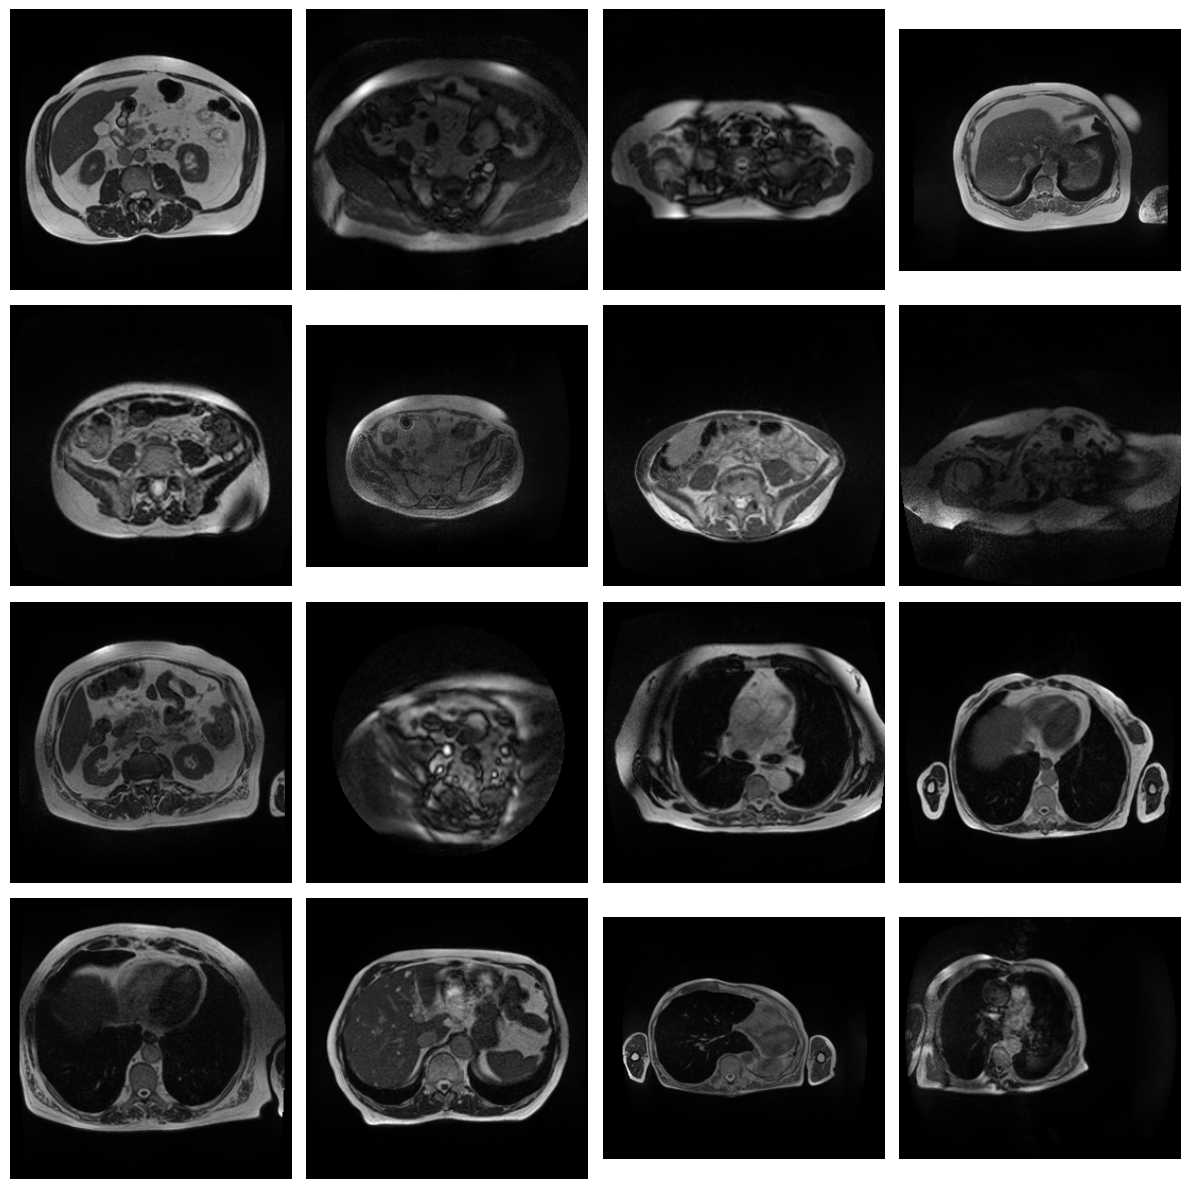

In [212]:
images = []
for i in range(16):
    image_path = random_sample(train_root_path)
    image = open_image(image_path, train_root_path, gray_scale=True)
    images.append(image)

# Display the 8-bit images in a 3x3 grid using matplotlib
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 🟡 Draw segments on image

case115/case115_day0/scans/slice_0104_266_266_1.50_1.50.png
case35/case35_day12/scans/slice_0073_276_276_1.63_1.63.png
case7/case7_day0/scans/slice_0007_266_266_1.50_1.50.png


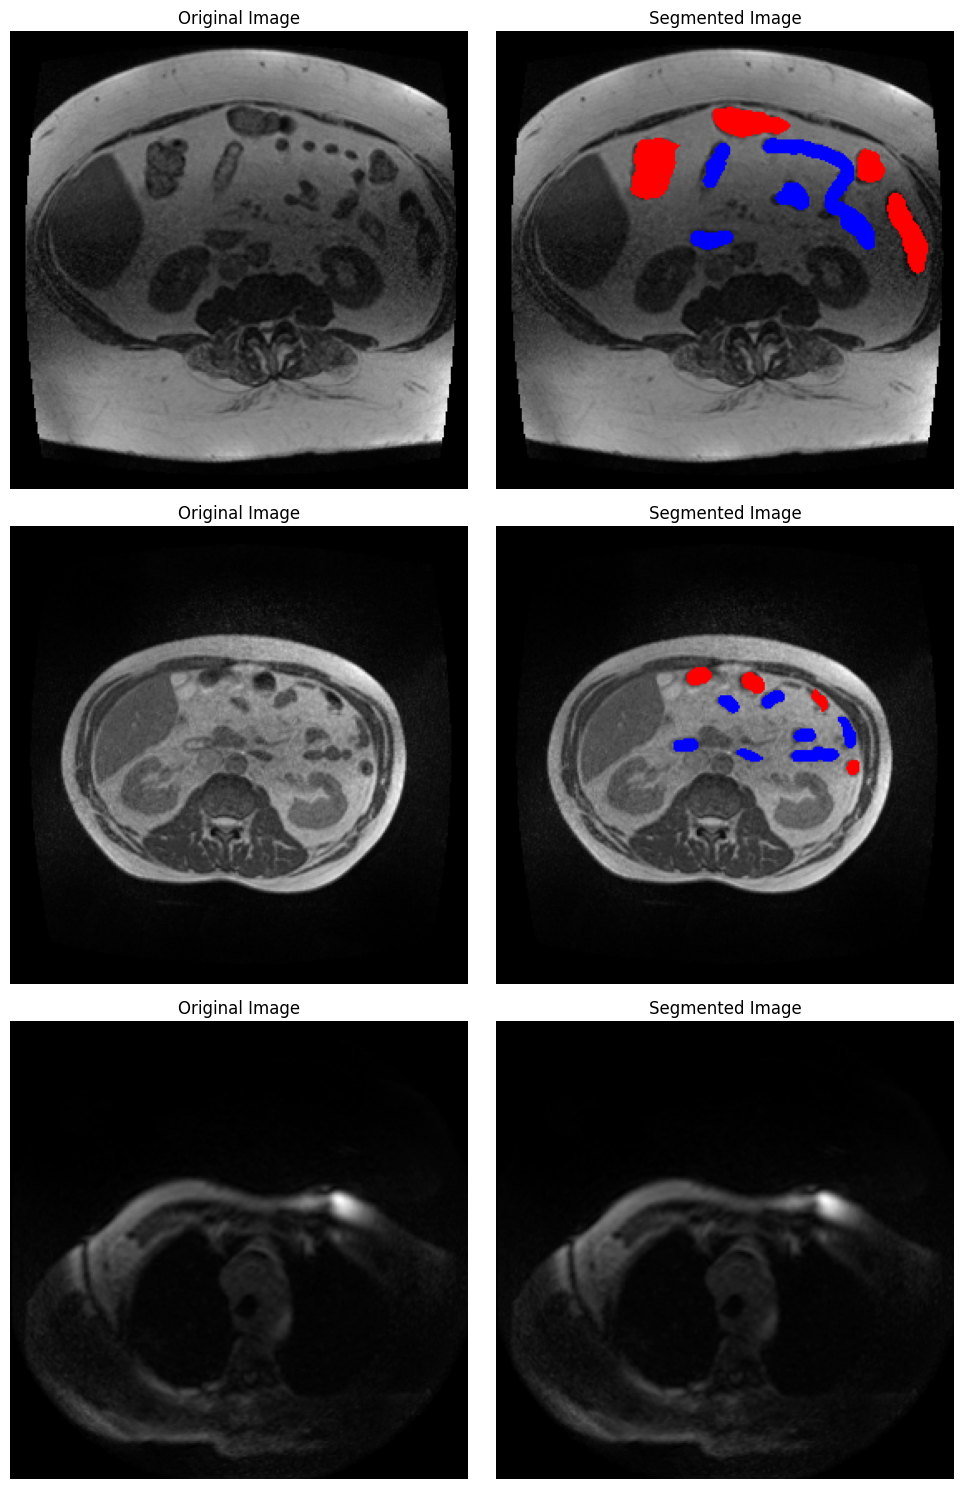

In [210]:
# image_path = "case123/case123_day20/scans/slice_0092_266_266_1.50_1.50.png"
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    image_path = random_sample(train_root_path)
    print(image_path)
    
    # Open Image
    color_image = open_image(image_path, train_root_path, gray_scale=False)
    original_image = open_image(image_path, train_root_path, gray_scale=True)
    
    masks = find_all_anns(image_path, ann_path, train_root_path)
    
    color_image = mask_image(color_image, masks)
    
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Segmented Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 🟠 Custom dataset

## 🟠 Dataloader

# 🔴 **Model**

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model =

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model =
optimizer = torch.optim.SGD(model.parameters(), lr=, momentum=0.9)

In [ ]:
num_epochs = ...
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, ..., loss_fn, optimizer, metric, epoch)

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs =

for lr in [...]:
  print(f'LR={lr}')

  model =
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_set, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define train dataloader.

In [ ]:
set_seed(seed)
train_loader =

🔰 Define model.

In [ ]:
set_seed(seed)
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

# 🔴 **Segment**

🔰 Your mission is to write a `segmentation` function and use a test image to see the prediction of the model.

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()